# Exploring RAG Applications in LangChain

This notebook builds upon https://www.sakunaharinda.xyz/ragatouille-book/2_Query_Transformation.html

## Notebook setup

Install and load necessary libraries.

In [ ]:
%%capture
!pip install langchain langchain_community langchain_core langchain_openai langchainhub pypdf chromadb

In [ ]:
from langchain_community.document_loaders import PyPDFLoader, DirectoryLoader
from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
import os

Load OpenAI API key

In [ ]:
from google.colab import userdata

# Load the OpenAI API key from Colab secrets
openai_api_key = userdata.get('OPENAI_API_KEY')
if openai_api_key is None:
    raise ValueError("OpenAI API key not found. Please add your API key to the Colab secrets.")

# Set the environment variable for OpenAI API key
os.environ["OPENAI_API_KEY"] = openai_api_key


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  warn_deprecated(


Load documents from /data folder

In [ ]:
# Load documents
loader = DirectoryLoader('data/',glob="*.pdf",loader_cls=PyPDFLoader)
documents = loader.load()

# Split text into chunks
text_splitter  = RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap=20)
text_chunks = text_splitter.split_documents(documents)

# Create vector embeddings and build vector store (using ChromaDB)
vectorstore = Chroma.from_documents(documents=text_chunks,
                                    embedding=OpenAIEmbeddings(),
                                    persist_directory="data/vectorstore")
vectorstore.persist()

Test the vector store with a simple similarity search query

In [ ]:
vectorstore.similarity_search("What is BASEL III?")

[Document(page_content='High -level summary of Basel III reforms  1 \n This note summarises the main features of the finalised Basel III reforms. The standards text, which provides \nthe full details of the reforms, is published separately and is available on the BIS website at \nwww.bis.org/bcbs/publ/d424.htm . \nThe Basel III framework is a central element of the Basel Committee’s response to the global \nfinancial crisis. It addresses a number of shortcomings in the pre -crisis regulatory framework and provides', metadata={'page': 4, 'source': 'data/d424_hlsummary.pdf'}),
 Document(page_content='Basel Committee  \non Banking Supervision  \n   \n \n  High -level summary of \nBasel III r eforms  \n \n   \n \nDecember  2017', metadata={'page': 0, 'source': 'data/d424_hlsummary.pdf'}),
 Document(page_content='The Basel III reforms replace the existing Basel I I floor with a floor based on the revised Basel III \nstandardised approaches. Consist ent with the original floor, the revised f

# 1. Creating a Simple RAG Model

## Initialise Retriever
Set to return top 5 results. This will be based on the most similar documents to a given query.

In [ ]:
retriever = vectorstore.as_retriever(search_kwargs={'k':5})

Create the prompt by importing an existing LangChain hub prompt (available here: https://smith.langchain.com/hub/rlm/rag-prompt):

*You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.*

*Question: {question}*

*Context: {context}*

*Answer:*

In [ ]:
prompt = hub.pull('rlm/rag-prompt')
prompt

ChatPromptTemplate(input_variables=['context', 'question'], metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"))])

## Creating the Question Answering (QA) Chain
Instead of directly adding the retrieved Document objects as the context, we use format_docs method to get the page_content of each retrieved document without metadata and concatenate them as the context. This ensures the LLM only recieves the pertinent information as context.

Then we define the QA chain where the retriever's formatted output is used as the context, and the user's question is passed unchanged through the RunnablePassthrough. This context and question are then applied to the prompt, which formats them for the language model (LLM). The LLM generates the answer, which is finally processed by the StrOutputParser to ensure the output is readable and well-structured.

In [ ]:
# LLM
llm = ChatOpenAI(model_name="gpt-4", temperature=0) # Increase temp for more creative answers

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain using LangChain Expression Language
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [ ]:
rag_chain.invoke("What is BASEL III?")

'BASEL III is a regulatory framework developed by the Basel Committee in response to the global financial crisis. It addresses shortcomings in the pre-crisis regulatory framework and includes reforms such as a revised floor for regulatory capital benefits and a capital charge for potential mark-to-market losses of derivative instruments. The framework aims to limit the extent to which banks can derive benefits from using internal models relative to standardized approaches.'

# 2. Monitoring the RAG Chain (LangSmith)

LangSmith is a tool designed to provide tracing and monitoring features for your language model workflows using LangChain. Tracing with LangSmith allows you to log and visualise the execution flow of your model pipelines, capturing detailed information about each step. This includes monitoring inputs and outputs, tracking execution times, and identifying errors.

Tracing with LangSmith can be implemented by setting the LANGCHAIN_TRACING_V2 env variable and connecting to the Langsmith API.

A screenshot of the trace can be seen below.

In [ ]:
# Set the environment variable
os.environ['LANGCHAIN_TRACING_V2'] = 'true'

# Load Langsmith API key
langsmith_api_key = userdata.get('LANGCHAIN_API_KEY')
if langsmith_api_key is None:
    raise ValueError("Langsmith API key not found. Please add your API key to the Colab secrets.")

# Set the environment variable for Langsmith API key
os.environ["LANGCHAIN_API_KEY"] = langsmith_api_key


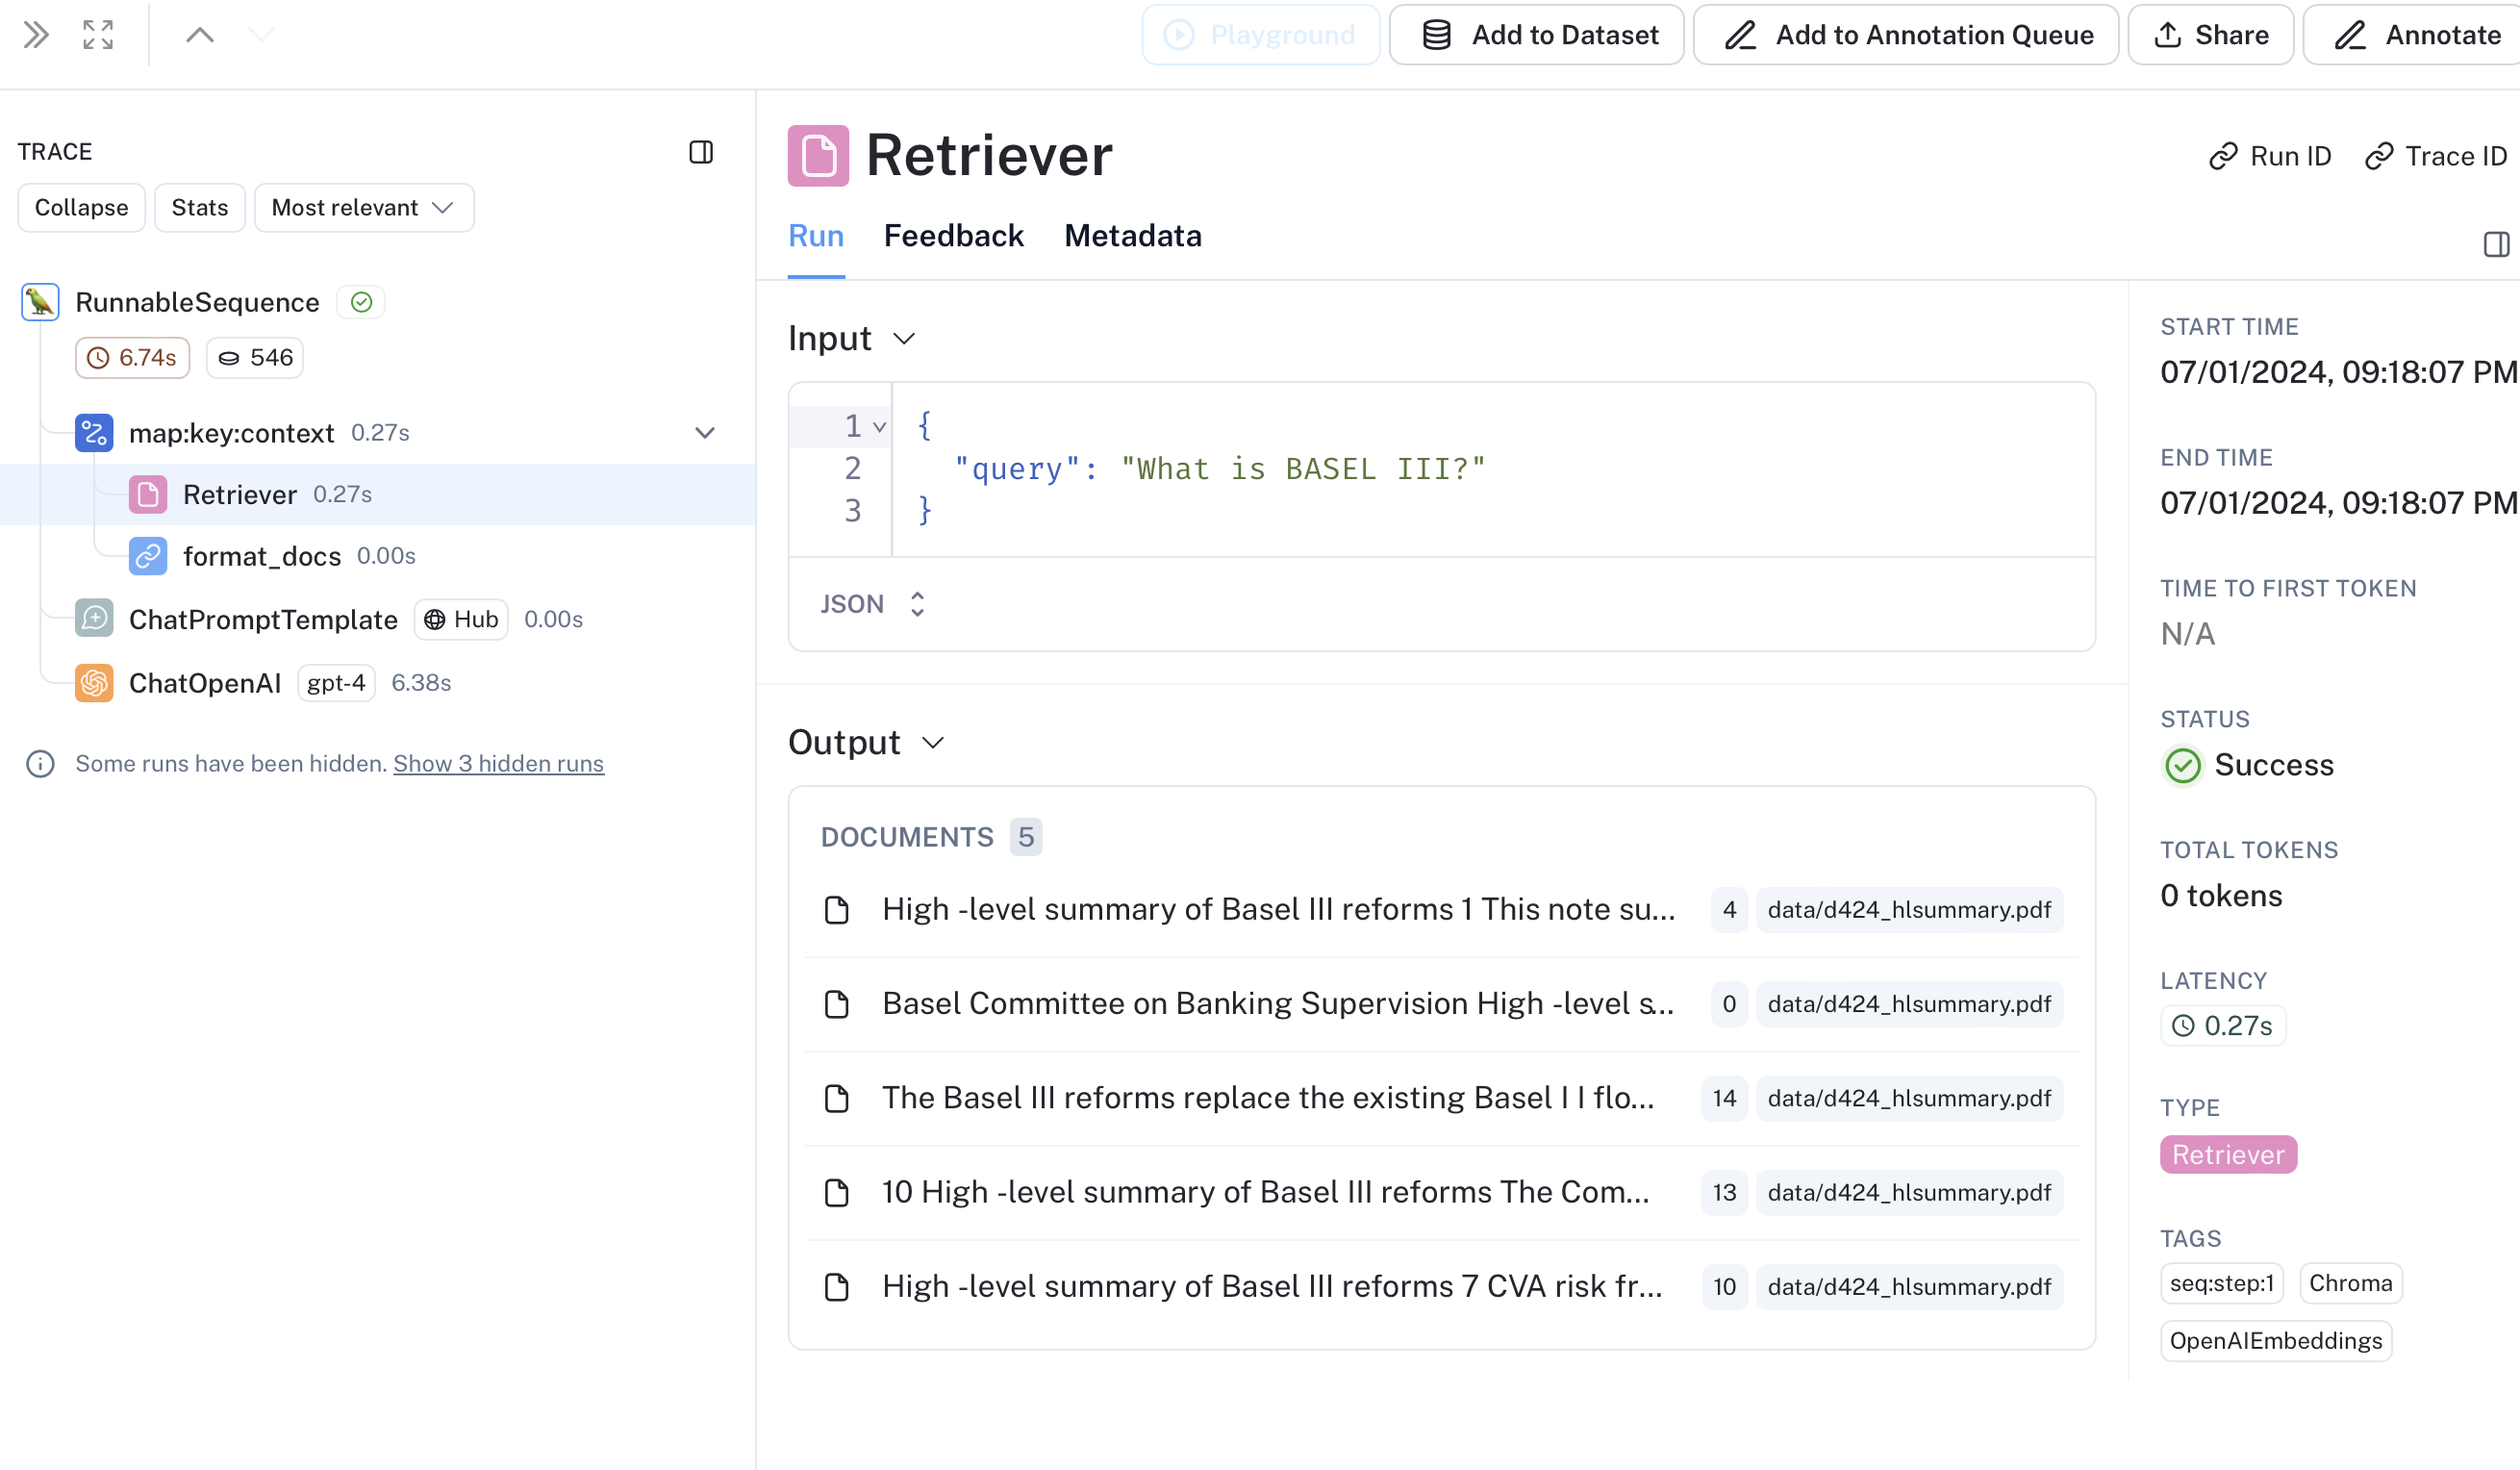

# 3. Query Transformation

*   Multi-query: re-writes the question in different perspectives, i.e. generate 5 similar questions to the user's question.
*   RAG Fusion: re-writes the question in different perspectives, and then  ranks the documents retrieved for each question to provide the most relevant information to answer the original question.
*   Least-to-Most Prompting: break-down complex questions into mutiple sub problems and answer the final question using the sub problems and their answers as the context.
*   Step-back Prompting: generates a step-back question (more abstract or 'bigger picture') and use the retrieved documents for that step-back question as the additional context to answer the original question.

